# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.3 which is incompatible.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

from IPython.display import clear_output

import torch

import time
from unityagents import UnityEnvironment
from ddpg_agentx import OUNoise
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from ddpg_agentx import Agent
from ddpg_agentx import ReplayBuffer
from ddpg_agentx import MultiagentWrapper

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [3]:
from unityagents import UnityEnvironment
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [8]:
#for i in range(5):                                         # play game for 5 episodes
#    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#    states = env_info.vector_observations                  # get the current state (for each agent)
#    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#    while True:
#        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#        next_states = env_info.vector_observations         # get next state (for each agent)
#        rewards = env_info.rewards                         # get reward (for each agent)
#        dones = env_info.local_done                        # see if episode finished
#        scores += env_info.rewards                         # update the score (for each agent)
#        states = next_states                               # roll over states to next time step
#        if np.any(dones):                                  # exit loop if episode finished
#            break
#    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


In [6]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
UPDATE_INTERVAL = 4    # The number of time steps after which the agents are retrained
UPDATE_STEPS = 1       # The number of minibatches that are used for a retraining of the agents
NOISE_LEVEL=0.7
NOISE_DECAY=0.9999
RANDOM_SEED=7
NUM_AGENTS=2
SOLUTION_THRESHOLD=0.5

In [7]:
replaybuffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, RANDOM_SEED)

agents = MultiagentWrapper(RANDOM_SEED, BATCH_SIZE, replaybuffer)

def ddpg(n_episodes=2000, noise_level=NOISE_LEVEL, noise_decay=NOISE_DECAY):
    total_t = 0
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations
        for agent in agents.agents:
            agent.reset()
        
        scores_agents = np.zeros(NUM_AGENTS)
        for t in range(0, 1000):
            total_t += 1
            actions = agents.act(states, noise_level)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            scores_agents += np.array(env_info.rewards)
            replaybuffer.add(states, actions, rewards, next_states, dones)
            
            if total_t%UPDATE_INTERVAL==0:
                for _ in range(0, UPDATE_STEPS):
                    agents.learn()

            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break

        scores_deque.append(np.max(scores_agents)) # as discussed maximum of both agents
        scores.append(np.concatenate((scores_agents, (np.mean(scores_deque),))))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tNoise Level: {:.2f}'.format(i_episode, np.mean(scores_deque), scores_deque[-1], noise_level))
        else:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tNoise Level: {:.2f}'.format(i_episode, np.mean(scores_deque), scores_deque[-1], noise_level), end="")
            
        noise_level *= noise_decay

        if np.mean(scores_deque) >= SOLUTION_THRESHOLD:
            print()
            print('Environment solved! Saving agent weights')
            for agentNr in range(0, NUM_AGENTS):
                # torch.save(agents.agents[agentNr].actor_local.state_dict(), 'model_weights/checkpoint_actor_{0}.pth'.format(agentNr))
                # torch.save(agents.agents[agentNr].critic_local.state_dict(), 'model_weights/checkpoint_critic_{0}.pth'.format(agentNr))
                torch.save(agents.agents[agentNr].actor_local.state_dict(), 'checkpoint_actor_{0}.pth'.format(agentNr))
                torch.save(agents.agents[agentNr].critic_local.state_dict(), 'checkpoint_critic_{0}.pth'.format(agentNr))

            break

    return scores

scores = ddpg(n_episodes=10000)



Episode 100	Average Score: 0.01	Score: 0.00	Noise Level: 0.69
Episode 200	Average Score: 0.01	Score: 0.00	Noise Level: 0.69
Episode 300	Average Score: 0.01	Score: 0.00	Noise Level: 0.68
Episode 400	Average Score: 0.02	Score: 0.00	Noise Level: 0.67
Episode 500	Average Score: 0.04	Score: 0.09	Noise Level: 0.67
Episode 600	Average Score: 0.08	Score: 0.10	Noise Level: 0.66
Episode 700	Average Score: 0.08	Score: 0.09	Noise Level: 0.65
Episode 800	Average Score: 0.09	Score: 0.10	Noise Level: 0.65
Episode 900	Average Score: 0.12	Score: 0.20	Noise Level: 0.64
Episode 1000	Average Score: 0.30	Score: 0.10	Noise Level: 0.63
Episode 1100	Average Score: 0.40	Score: 0.09	Noise Level: 0.63
Episode 1113	Average Score: 0.50	Score: 1.60	Noise Level: 0.63
Environment solved! Saving agent weights


Plots for the Performance

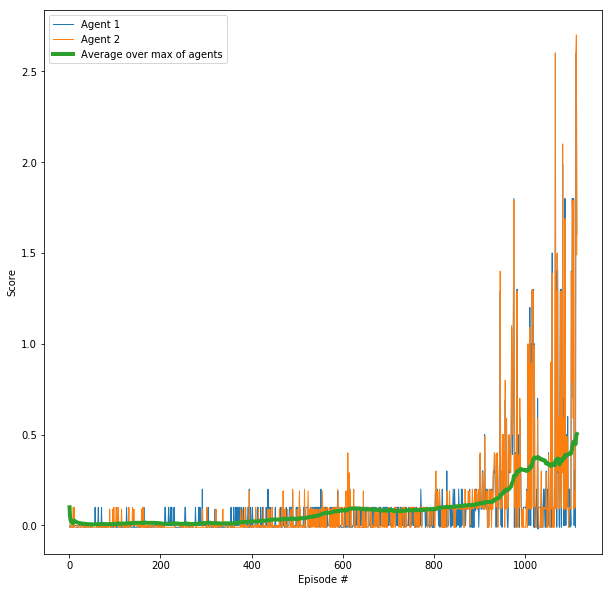

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
for agentNr in range(0, NUM_AGENTS):
    plt.plot(np.arange(1, len(scores)+1), [score[agentNr] for score in scores], label='Agent {}'.format(agentNr+1), linewidth=1)
plt.plot(np.arange(1, len(scores)+1), [score[NUM_AGENTS] for score in scores], label='Average over max of agents', linewidth=4)
plt.ylabel('Score')
plt.xlabel('Episode #')
ax.legend()
plt.show()

In [12]:
replaybuffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, RANDOM_SEED)

agents = MultiagentWrapper(RANDOM_SEED, BATCH_SIZE, replaybuffer)

for agentNr in range(0, NUM_AGENTS):
    agents.agents[agentNr].actor_local.load_state_dict(torch.load('checkpoint_actor_{0}.pth'.format(agentNr)))
    agents.agents[agentNr].critic_local.load_state_dict(torch.load('checkpoint_critic_{0}.pth'.format(agentNr)))

def run_ddpg():
    for episode in range(0, 3):
        print("Running Episode Nr {0}, please check graphical output window".format(episode+1))
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations
        for agent in agents.agents:
            agent.reset()
        scores_agents = np.zeros(num_agents)
        for t in range(0, 500):
            actions = agents.act(states, 0.0)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores_agents += np.array(env_info.rewards)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
            time.sleep(0.01)
            if t == 499:
                print("Quitting after 500 timesteps so that it doesn't go on forever")
                break
        print("The agents got the following scores: ", scores_agents)
   
run_ddpg()

Running Episode Nr 1, please check graphical output window
The agents got the following scores:  [ 0.    0.09]
Running Episode Nr 2, please check graphical output window
Quitting after 500 timesteps so that it doesn't go on forever
The agents got the following scores:  [ 1.30000002  1.30000002]
Running Episode Nr 3, please check graphical output window
Quitting after 500 timesteps so that it doesn't go on forever
The agents got the following scores:  [ 1.30000002  1.30000002]


When finished, you can close the environment.

In [13]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 